<div style="margin-bottom: 30px; text-align: center">
    <h1>Pneumonia Admission Predictor: Training</h1>
    <p style="text-align: center;">Jan Maverick M. Juat, Dionmelle J. Pardilla, Sthanly Paul L. Malapit, Darylle P. Villanueva </p>
</div>
This notebook will serve as the setting for preprocessing and training phase for pneumonia predictor model.

> *As of the moment, the researchers will use a randomly generated dataset,
> which contains the ideal set of features and values and doesn't require much preprocessing. Hence,
> the preprocessing part of this notebook will be temporarily skipped.*

## Bootstrap

The ibraries, dataset, and needed variables are loaded in this section.

In [2]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split

from pneumonia_predictor.backend.data_fetcher import load_data
from pneumonia_predictor.backend.rf_active_smote import RfActiveSMOTE
from pneumonia_predictor.backend.rf_smote import RfSMOTE
from pneumonia_predictor.backend.utils import get_feature_target_set

In [6]:
DATASET = load_data("pneumonia_sample")
TARGET = "pneumonia"
TEST_SIZE = 0.3
N_TREES = 100  # n_estimators for RandomForestClassifier
N_ITERATIONS = 5

## Pre-training

Create testing and training sets using Scikit-Learn's `train_test_split`. The split size will be:
- 70% for training
- 30% for testing (defined at `TEST_SIZE` variable above)

In [7]:
X, y = get_feature_target_set(DATASET, TARGET)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42
)

In [9]:
X_train.to_csv("datasets/X_train.csv", index=False)
y_train.to_csv("datasets/y_train.csv", index=False)
X_test.to_csv("datasets/X_test.csv", index=False)
y_test.to_csv("datasets/y_test.csv", index=False)

## Model Training

## Training with RF + Active SMOTE

`RfActiveSMOTE` combines `ActiveSMOTE` and `RandomForestClassifier`. The training undergoes several `N_ITERATIONS` (defined in [Bootstrap](#Bootstrap)) that will generate synthetic samples to balance the dataset.

In [10]:
rf_active_smote = RfActiveSMOTE(X_train, y_train, X_test, y_test, TARGET)

A brief overview `model.train(n_iterations: int)`'s implementation (can be accessed at
`pneumonia_predictor/backend/rf_active_smote.py`):
```python
RfActiveSMOTE.train(n_iterations: int):
    RfActiveSMOTE.fit_classifier()
    ActiveSMOTE.probabilities = RfActiveSMOTE.classifier.predict_proba(X_train)
    for i in range(n_iterations):
        ActiveSMOTE.uncertainty_sampling()
        ActiveSMOTE.diversity_sampling()
        ActiveSMOTE.create_synthetic_samples(sampling_ratio)
        concat(total_synthetic_samples, current_synthetic_samples)
        RfActiveSMOTE.fit_classifier()
```

The `ActiveSMOTE` implementation can be accessed at `pneumonia_predictor/backend/active_smote.py`.

In [11]:
rf_active_smote.train(N_ITERATIONS)

In [12]:
rf_active_smote.save("pneumonia_predictor")

## Sample prediction

In [13]:
pneumonia_predictor = joblib.load("saved_models/pneumonia_predictor.pkl")

In [20]:
all_cols = [
    "age",
    "sex",
    "fatigue",
    "cough_phlegm",
    "chronic_resp_disease",
    "chronic_kidney_disease",
    "diabetes_mellitus",
    "heart_failure",
    "cancer",
    "systoic_bp",
    "dias_bp",
    "pulse_rate",
    "resp_rate",
    "temp",
    "hemoglobin",
    "hematocrit",
    "rbc",
    "wbc",
    "platelets",
    TARGET,
]
new_data = pd.DataFrame(
    [[48,0,1,0,0,1,0,0,1,212,111,83,46,36.27,154,0.15,4.48,15.91,457,1]],
    columns=all_cols
)
new_data

,age,sex,fatigue,cough_phlegm,chronic_resp_disease,chronic_kidney_disease,diabetes_mellitus,heart_failure,cancer,systoic_bp,dias_bp,pulse_rate,resp_rate,temp,hemoglobin,hematocrit,rbc,wbc,platelets,pneumonia
0,48,0,1,0,0,1,0,0,1,212,111,83,46,36.27,154,0.15,4.48,15.91,457,1


In [21]:
X_new = new_data.drop(TARGET, axis=1)
X_new

,age,sex,fatigue,cough_phlegm,chronic_resp_disease,chronic_kidney_disease,diabetes_mellitus,heart_failure,cancer,systoic_bp,dias_bp,pulse_rate,resp_rate,temp,hemoglobin,hematocrit,rbc,wbc,platelets
0,48,0,1,0,0,1,0,0,1,212,111,83,46,36.27,154,0.15,4.48,15.91,457


In [22]:
pred = pneumonia_predictor.predict(X_new)

In [23]:
pred  # expected prediction: 1

array([1])

In [24]:
pred_probabilities = pneumonia_predictor.predict_proba(X_new)

In [25]:
pred_probabilities

array([[0.21, 0.79]])

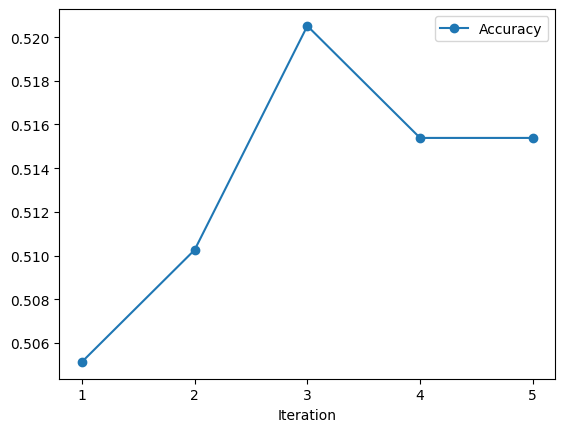

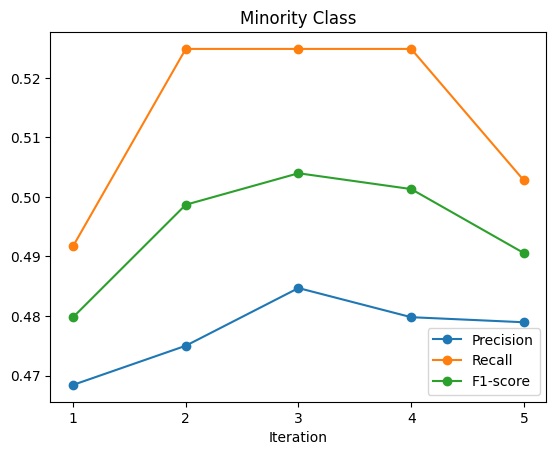

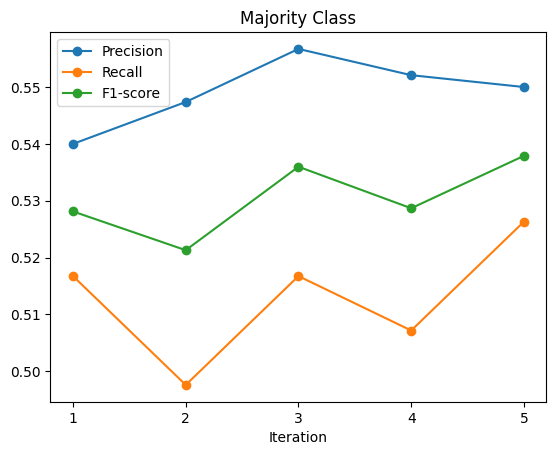

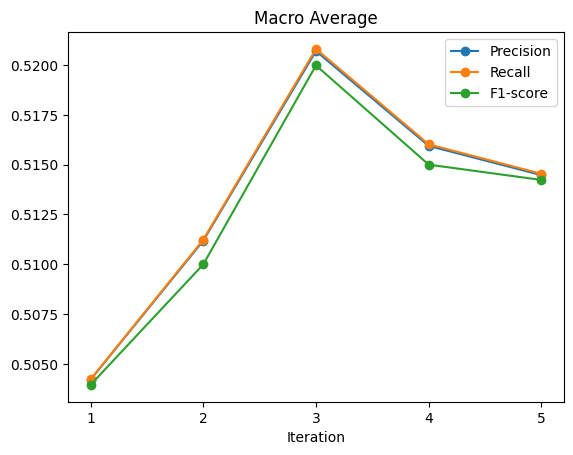

In [26]:
rf_active_smote.display_results("acc")
rf_active_smote.display_results("min")
rf_active_smote.display_results("maj")
rf_active_smote.display_results("avg")

## Using Random Forest + SMOTE Only

In [27]:
rf_smote = RfSMOTE(X_train, y_train, X_test, y_test, TARGET)

In [28]:
rf_smote.train()

In [29]:
pd.DataFrame(rf_smote.report)

,0,1,accuracy,macro avg,weighted avg
precision,0.516279,0.440000,0.482051,0.478140,0.480878
recall,0.531100,0.425414,0.482051,0.478257,0.482051
f1-score,0.523585,0.432584,0.482051,0.478085,0.481351
support,209.000000,181.000000,0.482051,390.000000,390.000000


In [30]:
rf_smote.save("pneumonia_predictor_rfsmote")

In [31]:
pneumonia_predictor = joblib.load("saved_models/pneumonia_predictor_rfsmote.pkl")

In [32]:
all_cols = [
    "age",
    "sex",
    "fatigue",
    "cough_phlegm",
    "chronic_resp_disease",
    "chronic_kidney_disease",
    "diabetes_mellitus",
    "heart_failure",
    "cancer",
    "systoic_bp",
    "dias_bp",
    "pulse_rate",
    "resp_rate",
    "temp",
    "hemoglobin",
    "hematocrit",
    "rbc",
    "wbc",
    "platelets",
    TARGET,
]
new_data = pd.DataFrame(
    [[48,0,1,0,0,1,0,0,1,212,111,83,46,36.27,154,0.15,4.48,15.91,457,1]],
    columns=all_cols
)
new_data


,age,sex,fatigue,cough_phlegm,chronic_resp_disease,chronic_kidney_disease,diabetes_mellitus,heart_failure,cancer,systoic_bp,dias_bp,pulse_rate,resp_rate,temp,hemoglobin,hematocrit,rbc,wbc,platelets,pneumonia
0,48,0,1,0,0,1,0,0,1,212,111,83,46,36.27,154,0.15,4.48,15.91,457,1


In [33]:
X_new = new_data.drop(TARGET, axis=1)
X_new

,age,sex,fatigue,cough_phlegm,chronic_resp_disease,chronic_kidney_disease,diabetes_mellitus,heart_failure,cancer,systoic_bp,dias_bp,pulse_rate,resp_rate,temp,hemoglobin,hematocrit,rbc,wbc,platelets
0,48,0,1,0,0,1,0,0,1,212,111,83,46,36.27,154,0.15,4.48,15.91,457


In [34]:
pred = pneumonia_predictor.predict(X_new)

In [35]:
pred

array([1])

In [36]:
pred_probabilities = pneumonia_predictor.predict_proba(X_new)

In [37]:
pred_probabilities

array([[0.18, 0.82]])